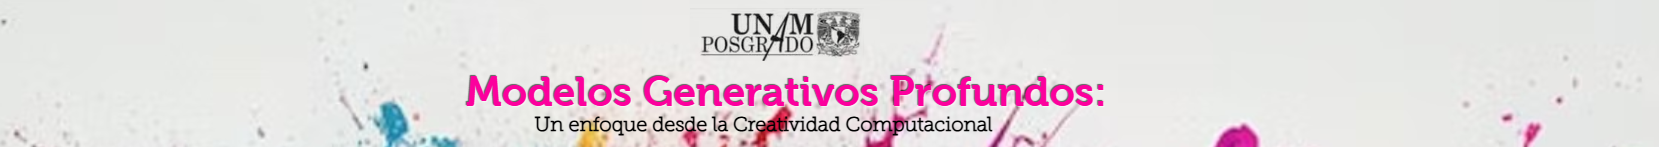


#CLIP Embeddings —
###Explorando el espacio conjunto texto-imagen

Este notebook permite experimentar con **CLIP (Contrastive Language-Image Pretraining)**, el modelo base que define el espacio multimodal compartido entre texto e imagen. DALL·E 2 aprovecha únicamente el text encoder de CLIP para generar embeddings de texto ya alineados con ese espacio visual.



### Objetivos didácticos
- Comprender cómo se codifican textos e imágenes en vectores comparables.
- Medir la similitud entre descripciones y contenidos visuales.
- Visualizar las relaciones semánticas en un espacio 2D (PCA).


###1. Instalar CLIP

###2. Importar librerías

In [1]:
import torch, clip
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd


###3. Carga de imágenes y descripciones

In [2]:
# Ejercicio 1: animales
# CLIP suele agrupar las imágenes de “dog” y “cat” cerca de “pet” y “domestic animal”, mientras “lion” se aproxima más a “wild animal”.
def carga_imagenes_ejercicio1():
    # Carpeta donde guardaste tus imágenes
    base_dir = "./Imagenes1"

    # Archivos locales en tu carpeta
    image_paths = [
        f"{base_dir}/leon1.jpg",
        f"{base_dir}/leon2.jpg",
        f"{base_dir}/leon3.jpg",
        f"{base_dir}/leon4.jpg",
        f"{base_dir}/leon5.jpg",
        f"{base_dir}/gato1.jpg",
        f"{base_dir}/gato2.jpg",
        f"{base_dir}/gato3.jpg",
        f"{base_dir}/gato4.jpg",
        f"{base_dir}/gato5.jpg",
        f"{base_dir}/perro1.jpg",
        f"{base_dir}/perro2.jpg",
        f"{base_dir}/perro3.jpg",
        f"{base_dir}/perro4.jpg",
        f"{base_dir}/perro5.jpg"
    ]

    # Prompts de texto para asociar
    text_prompts = [
        "a lion",
        "a cat",
        "a dog",
        "a wild animal",
        "a domestic animal",
        "a pet"
    ]

    return image_paths, text_prompts


In [3]:
#Ejercicio 2: diferentes tipos de medios de transporte
#El embedding de “bus” tiende a asociarse más con “public transportation”, mientras “bicycle” se separa semánticamente hacia objetos individuales o “a road scene”.
def carga_imagenes_ejercicio2():
    # Carpeta donde guardaste tus imágenes
    base_dir = "./Imagenes2"

    # Archivos locales en tu carpeta
    image_paths = [
        f"{base_dir}/auto1.jpg",
        f"{base_dir}/auto2.jpg",
        f"{base_dir}/auto3.jpg",
        f"{base_dir}/auto4.jpg",
        f"{base_dir}/auto5.jpg",
        f"{base_dir}/bus1.jpg",
        f"{base_dir}/bus2.jpg",
        f"{base_dir}/bus3.jpg",
        f"{base_dir}/bus4.jpg",
        f"{base_dir}/bus5.jpg",
        f"{base_dir}/bicicleta1.jpg",
        f"{base_dir}/bicicleta2.jpg",
        f"{base_dir}/bicicleta3.jpg",
        f"{base_dir}/bicicleta4.jpg",
        f"{base_dir}/bicicleta5.jpg"
    ]

    # Prompts de texto para asociar
    text_prompts = [
        "a car",
        "a bus",
        "a bicycle",
        "a vehicle",
        "public transportation",
        "a road scene"
    ]
    return image_paths, text_prompts


In [4]:
def mostrar_imagenes(image_paths, cols=None, figsize=(12, 6)):
    """
    Despliega en una cuadrícula las imágenes cargadas.

    Parámetros:
    - image_paths: lista de rutas a archivos de imagen.
    - cols: número de columnas (opcional). Si no se especifica, se calcula automáticamente.
    - figsize: tamaño de la figura en pulgadas.
    """
    total = len(image_paths)
    if total == 0:
        print("No hay imágenes para mostrar.")
        return

    # Calcular columnas automáticamente
    if cols is None:
        cols = min(5, total)  # hasta 5 columnas máximo
    rows = (total + cols - 1) // cols

    plt.figure(figsize=figsize)

    for i, path in enumerate(image_paths):
        plt.subplot(rows, cols, i + 1)
        try:
            img = Image.open(path)
            plt.imshow(img)
            plt.axis("off")
        except UnidentifiedImageError:
            plt.text(0.5, 0.5, "Imagen no válida", ha="center", va="center", fontsize=9)
            plt.axis("off")

    plt.tight_layout()
    plt.show()



In [5]:
import os 

def carga_imagenes_ejercicio3():
    # Carpeta donde guardaste tus imágenes
    base_dir = "./Imagenes3"

    # Archivos locales en tu carpeta
    image_paths = os.listdir(base_dir)
    image_paths = [os.path.join(base_dir, img) for img in image_paths if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    # Prompts de texto para asociar
    text_prompts = [
        "tacos",
        "mole",
        "pizza",
        "gnocchi",
        "pozole",
        "pasta",
        "birria",
        "spaghetti",
        "mexican food",
        "italian food",
        "food"
    ]
    return image_paths, text_prompts

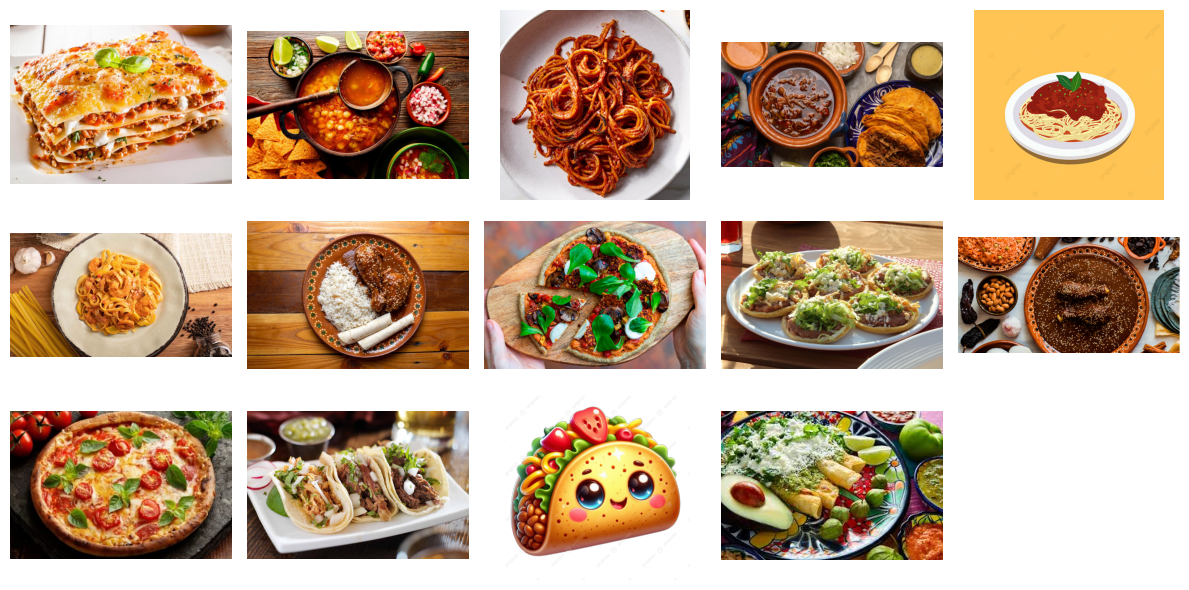

In [6]:
# Carga y muestra las imágenes de ejemplo (puedes reemplazarlas por otras)
image_paths, text_prompts = carga_imagenes_ejercicio3()
mostrar_imagenes(image_paths)


###4. Obtención de embeddings de texto e imagen

In [7]:
# Selección del dispositivo y carga del modelo CLIP

import os 

def setConfig():
    """
    Configura el dispositivo para PyTorch y spaCy según la disponibilidad de hardware.
    Devuelve el dispositivo configurado.
    """
    if torch.backends.mps.is_available():
        # Usar MPS (Metal Performance Shaders) en macOS
        device = torch.device("mps")
    elif torch.cuda.is_available():
        # Usar CUDA (GPU NVIDIA) si está disponible
        device = torch.device("cuda")
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    else:
        # Usar CPU como fallback
        device = torch.device("cpu")
    try:
        torch.ones(1, device=device)
    except Exception as e:
        print("Error:", e)
        raise e
    
    return device

device = setConfig()

model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
# Preprocesamiento de las imágenes

images = [preprocess(Image.open(path)).to(device) for path in image_paths]

# Preprocesamiento de los prompts

text_tokens = clip.tokenize(text_prompts).to(device)

/Users/roicort/GitHub/PCIC/GenAI/.venv/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
print(text_prompts[0])
print(text_tokens[0])

tacos
tensor([49406, 14090, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='mps:0',
       dtype=torch.int32)


In [10]:
# Generar los embeddings de imagen y texto con CLIP, y luego normalizarlos
# para que puedan compararse dentro del mismo espacio latente.

with torch.no_grad():
    image_embeddings = [model.encode_image(img.unsqueeze(0)) for img in images]
    image_embeddings = torch.vstack(image_embeddings)
    text_embeddings = model.encode_text(text_tokens)

# Normalización

image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

###5. Cálculo de similitud entre texto e imagen

In [11]:
# Calcular la similitud entre embeddings de imagen y texto
# - image_features @ text_features.T es el producto punto
# - Se multiplica por 100 para amplificar los valores de similitud antes de aplicar el softmax.

similarities = []
for img_emb in image_embeddings:
    sim = (img_emb @ text_embeddings.T) * 100
    similarities.append(sim.softmax(dim=-1).cpu().detach().numpy())




In [15]:
# Crear etiquetas automáticas a partir de las rutas de imagen
# (solo el nombre del archivo, sin la ruta completa)
image_labels = [path.split("/")[-1] for path in image_paths]

# Crear DataFrame de forma dinámica
df = pd.DataFrame(similarities, columns=text_prompts, index=image_labels)

# Mostrar con formato y gradiente de color
display(df.style.background_gradient(cmap="Blues").format("{:.2f}"))


,tacos,mole,pizza,gnocchi,pozole,pasta,birria,spaghetti,mexican food,italian food,food
lasagna.1jpg.jpg,0.00,0.00,0.03,0.00,0.00,0.23,0.00,0.05,0.03,0.63,0.03
pozole1.jpg,0.00,0.00,0.00,0.00,0.87,0.00,0.01,0.00,0.12,0.00,0.00
spaghetti.jpg,0.00,0.00,0.00,0.00,0.00,0.36,0.00,0.50,0.00,0.13,0.00
birria.jpg,0.01,0.00,0.00,0.00,0.33,0.00,0.40,0.00,0.26,0.00,0.00
pasta2.jpg,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.84,0.00,0.02,0.00
pasta1.jpg,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.10,0.00,0.32,0.01
mole2.jpg,0.00,0.09,0.00,0.01,0.35,0.00,0.14,0.00,0.26,0.03,0.13
pizza1.jpg,0.01,0.00,0.72,0.01,0.00,0.00,0.00,0.00,0.01,0.17,0.07
sopes1.jpg,0.77,0.00,0.00,0.00,0.08,0.00,0.03,0.00,0.12,0.00,0.00
mole1.jpg,0.01,0.23,0.00,0.00,0.11,0.00,0.25,0.00,0.36,0.01,0.02


###6. Visualización del espacio latente con PCA

Cada punto del gráfico es un vector de características (embedding) que CLIP ha generado para:

una imagen (puntos azules 🟦), o

una descripción textual (puntos naranjas 🟧).

CLIP los entrena para que ambos tipos de datos —imagen y texto— vivan en un mismo espacio semántico.
En ese espacio, cosas que “significan lo mismo” están cerca, aunque sean de modalidades distintas.

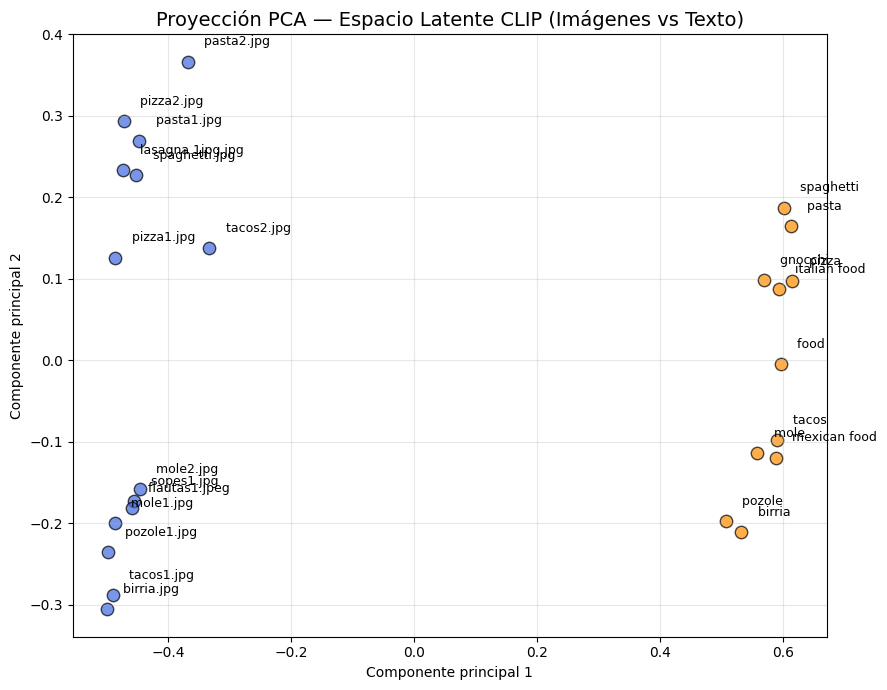

In [13]:
# Reducir embeddings (funciona con cualquier número de imágenes o textos)
pca = PCA(n_components=2)
all_embeddings = torch.cat([image_embeddings, text_embeddings]).cpu().numpy()
reduced = pca.fit_transform(all_embeddings)

# Crear etiquetas dinámicamente
image_labels = [f" {path.split('/')[-1]}" for path in image_paths]
text_labels = [f" {t}" for t in text_prompts]
labels = image_labels + text_labels

# Asignar colores automáticos
colors = (["royalblue"] * len(image_paths)) + (["darkorange"] * len(text_prompts))

# Gráfico
plt.figure(figsize=(9, 7))
for i, (x, y) in enumerate(reduced):
    plt.scatter(x, y, color=colors[i], s=80, edgecolors="k", alpha=0.7)
    plt.text(x + 0.02, y + 0.02, labels[i], fontsize=9)

plt.title("Proyección PCA — Espacio Latente CLIP (Imágenes vs Texto)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


###Conclusión
Este ejercicio permite observar cómo CLIP alinea descripciones textuales e imágenes dentro de un mismo espacio latente. Los embeddings más cercanos reflejan mayor similitud semántica.